In [1]:
import os 
import sys
import time
import glob
import pickle
import itertools
import logging
import pyprind
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')
%matplotlib inline


from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix
from sklearn.utils import shuffle

import utils
import data_prep as prep
import train_select as ts

In [2]:
random_state = 42
batch_dir = "dataset/batches"
val_ratio = .15
batch_size = 256
n_epochs = 50
validate_every = 50
print_every = batch_size * 2

In [3]:
npi = prep.prepare_npi(prep.npi_url)

naive = [True] * len(npi)
naive_acc = accuracy_score(naive, npi['op_longer'])
naive_f = fbeta_score(naive, npi['op_longer'], beta=.5)
print('')
print("=========== Benchmark score =========== ")
print("Accuracy score: {:.4f}".format(naive_acc))
print("F score: {:.4f}".format(naive_f))

INFO Data set PartD_Prescriber_PUF_NPI_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_NPI_15.zip
INFO successfully downloaded and uncompressed
INFO Data cleaning completed
INFO New features are added

=========== Benchmark score =========== 
Accuracy score: 0.1537
F score: 0.4759


We will compare five candidate classification models that support partial fit - linear support vector machine, logistic regression, perceptron, passive aggressive classifier, and Naive Bayes multinormial classifier. 

In [4]:
partial_fit_classifiers = {
    'SGD-SVM': SGDClassifier(random_state=random_state, loss='hinge'),
    'SGD-Log': SGDClassifier(random_state=random_state, loss='log'),
    'Perceptron': Perceptron(random_state=random_state),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(random_state=random_state)
}

# Split datasets 

In [5]:
train_batch_names, test_batch_names, val_batch_names = ts.get_batchnames(split_val=True)

number of train batches: 60
Number of validation batches: 10
number of test batches: 12


In [6]:
val_features, val_labels = ts.concat_batches(val_batch_names)

INFO Concatenating 10 batches


0% [##########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04




# Train on the training batches

In [7]:
def initialize_stats(partial_fit_classifiers):
    results = {}
    for clf_name in partial_fit_classifiers:
        stats = {
            'n_train': [],
            'train_time': [],
            'pred_time': [],
            'acc_train': [],
            'acc_test': [],
            'f_train': [],
            'f_test': []
        }
        results[ clf_name ] = stats
    return results

In [8]:
def train_predict(partial_fit_classifiers, train_batch_names, val_features, val_labels):
    classes = np.array([ 0, 1 ])
    results = initialize_stats(partial_fit_classifiers)
    steps = 0

    for batch_i in range(len(train_batch_names)):
        for X_train, y_train in ts.load_train_batches(train_batch_names, batch_i, batch_size):
            for clf_name, clf in partial_fit_classifiers.items():
                steps += 1
                # train via partial fit
                tick = time.time()
                clf.partial_fit(X_train, y_train, classes=classes)
                train_time = time.time() - tick

                # predict
                tick = time.time()
                pred_train = clf.predict(X_train)
                pred_time = time.time() - tick

                pred_train = clf.predict(X_train)
                results[ clf_name ][ 'train_time' ].append(train_time)
                results[ clf_name ][ 'pred_time' ].append(pred_time)
                results[ clf_name ][ 'n_train' ].append(X_train.shape[ 0 ])
                results[ clf_name ][ 'acc_train' ].append(accuracy_score(y_train, pred_train))
                results[ clf_name ][ 'f_train' ].append(fbeta_score(y_train, pred_train, beta=.5))

        X_val, y_val = ts.load_random_test_batch(val_features, val_labels, batch_size)
        for clf_name, clf in partial_fit_classifiers.items():
            pred_val = clf.predict(X_val)
            results[ clf_name ][ 'acc_test' ].append(accuracy_score(y_val, pred_val))
            results[ clf_name ][ 'f_test' ].append(fbeta_score(y_val, pred_val, beta=.5))
            

        logging.info(
            "batch {} / {} ================================".format(batch_i + 1, len(train_batch_names)))
        # logging.info("Number of validation sample: {}".format(X_train.shape[ 0 ]))
        logging.info("F-beta score (beta=0.5) on training set:")
        logging.info("SGD-SVM: {}".format(results[ 'SGD-SVM' ][ 'f_train' ][ -1 ]))
        logging.info("SGD-Log: {}".format(results[ 'SGD-Log' ][ 'f_train' ][ -1 ]))
        logging.info("Perceptron: {}".format(results[ 'Perceptron' ][ 'f_train' ][ -1 ]))
        logging.info("NB Multinomial: {}".format(results[ 'NB Multinomial' ][ 'f_train' ][ -1 ]))
        logging.info("PA: {}".format(results[ 'Passive-Aggressive' ][ 'f_train' ][ -1 ]))
        # logging.info("==========================================")

    return results

In [9]:
results = train_predict(partial_fit_classifiers, train_batch_names, val_features, val_labels) 

INFO batch 1 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.6440677966101696
INFO SGD-Log: 0.6109324758842443
INFO Perceptron: 0.5752212389380531
INFO NB Multinomial: 0.6477732793522267
INFO PA: 0.6507936507936508
INFO batch 2 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.7333333333333333
INFO SGD-Log: 0.7142857142857142
INFO Perceptron: 0.7971014492753623
INFO NB Multinomial: 0.7272727272727274
INFO PA: 0.7333333333333333
INFO batch 3 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.743801652892562
INFO SGD-Log: 0.7092198581560284
INFO Perceptron: 0.7560975609756098
INFO NB Multinomial: 0.5809128630705395
INFO PA: 0.7182320441988951
INFO batch 4 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.6493506493506493
INFO SGD-Log: 0.6741573033707865
INFO Perceptron: 0.7664233576642336
I

INFO SGD-SVM: 0.8620689655172415
INFO SGD-Log: 0.8064516129032259
INFO Perceptron: 0.8333333333333334
INFO NB Multinomial: 0.7407407407407408
INFO PA: 0.8823529411764706
INFO batch 34 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.6701030927835052
INFO SGD-Log: 0.7303370786516854
INFO Perceptron: 0.8235294117647058
INFO NB Multinomial: 0.4744525547445256
INFO PA: 0.7522123893805309
INFO batch 35 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.8021390374331551
INFO SGD-Log: 0.8064516129032256
INFO Perceptron: 0.8285714285714286
INFO NB Multinomial: 0.5893536121673005
INFO PA: 0.8187134502923976
INFO batch 36 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.7000000000000001
INFO SGD-Log: 0.6451612903225806
INFO Perceptron: 0.47619047619047616
INFO NB Multinomial: 0.48245614035087725
INFO PA: 0.5384615384615385
INFO batch 37 / 60 =====

# Plot results

### 1. Run time

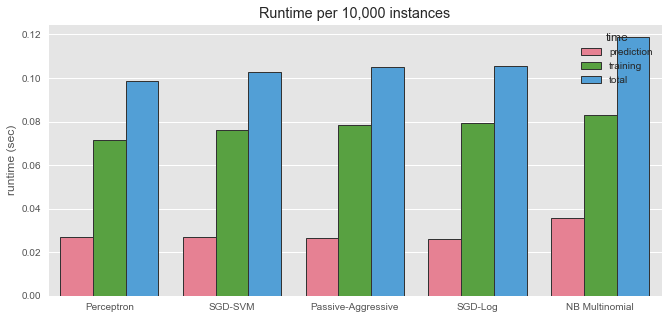

In [10]:
time_res = ts.get_time_res(results)
ts.plot_time(time_res)

 

## 2. Accuracy and F-beta score

In [11]:
def plot_score(results, window=20):
    my_col = sns.color_palette("husl", 5)
    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(121)

    for i, clf_name in enumerate(partial_fit_classifiers.keys()):
        plt.plot(pd.Series(results[ clf_name ][ 'acc_train' ]).rolling(window=window).mean(),
                 color=my_col[ i ], linewidth=2)
    plt.ylabel("Accuracy")
    plt.xlabel("Training steps")
    plt.legend(loc="best", labels=partial_fit_classifiers.keys())
    plt.title("Accuracy on training set")

    ax2 = plt.subplot(122, sharey=ax1)
    for i, clf_name in enumerate(partial_fit_classifiers.keys()):
        plt.plot(pd.Series(results[ clf_name ][ 'f_train' ]).rolling(window=window).mean(),
                 color=my_col[ i ], linewidth=2)
    plt.ylabel("F-score")
    plt.xlabel("Training steps")
    # plt.legend(loc="best", labels=partial_fit_classifiers.keys())
    plt.title("F score (beta=0.5) on training set")
    plt.savefig("assets/compare_score.png")
    plt.show()
    
#plot_score(results, window=150)

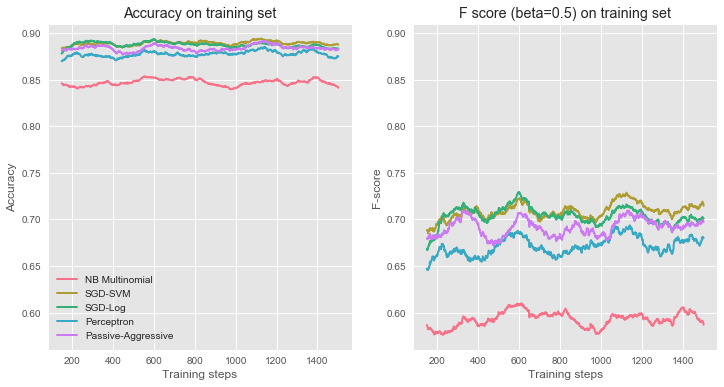

In [12]:
plot_score(results, window=150)

In [13]:
mean_scores, acc_test, f_test = ts.get_test_score(results)
mean_scores

,acc_test_mean,f_test_mean
SGD-Log,0.869271,0.642768
SGD-SVM,0.858398,0.612183
NB Multinomial,0.839518,0.560809
Perceptron,0.831120,0.536410
Passive-Aggressive,0.831706,0.535115


In [14]:
# INFO Avg test scores:                     acc_test_mean  f_test_mean
# SGD-Log                  0.869271     0.642768
# SGD-SVM                  0.858398     0.612183
# NB Multinomial           0.839518     0.560809
# Perceptron               0.831120     0.536410
# Passive-Aggressive       0.831706     0.535115

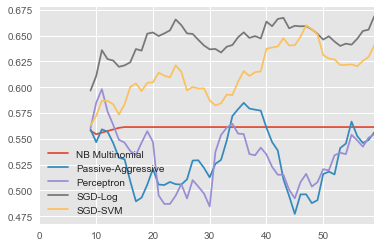

In [15]:
pd.rolling_mean(f_test, 10).plot()

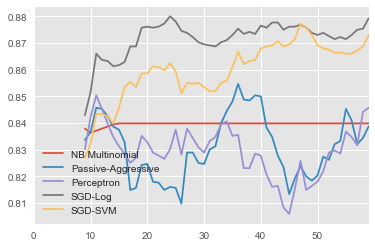

In [16]:
pd.rolling_mean(acc_test, 10).plot()

# Hyperparameter tuning via grid search

As GridSearchCV in scikit-learn doesn't support algorithms with partial fit, let's manually search the hyperparameter space. 

In [17]:
loss = ['log', 'hinge']
alpha = [.000001, .00001, .0001, .001]
l1_ratio = [0., .1, .2, .3, .4, .5, .6, .7, .8, .9]

In [19]:
search_res = ts.sgd_grid_search(train_batch_names, val_features, val_labels, loss, alpha, l1_ratio, random_state)


INFO 1/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.0
INFO Validation F-score: 0.5154639175257731

INFO 2/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.1
INFO Validation F-score: 0.6050955414012742

INFO 3/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.2
INFO Validation F-score: 0.5263157894736842

INFO 4/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.3
INFO Validation F-score: 0.6201550387596899

INFO 5/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.4
INFO Validation F-score: 0.6687898089171973

INFO 6/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.5
INFO Validation F-score: 0.4887218045112781

INFO 7/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.6
INFO Validation F-score: 0.4705882352941176

INFO 8/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.7
INFO Validation F-sc

INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.3
INFO Validation F-score: 0.6194690265486724

INFO 65/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.4
INFO Validation F-score: 0.6201550387596899

INFO 66/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.5
INFO Validation F-score: 0.6637168141592918

INFO 67/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.6
INFO Validation F-score: 0.6410256410256412

INFO 68/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.7
INFO Validation F-score: 0.6666666666666669

INFO 69/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.8
INFO Validation F-score: 0.7079646017699117

INFO 70/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.9
INFO Validation F-score: 0.6410256410256412

INFO 71/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.001, l1_ratio: 0.0
INFO Validation F-score: 0.668

In [20]:
search_res = search_res.sort_values(by='val_f_score', ascending=False)
search_res.iloc[:10, :]

,alpha,l1_ratio,loss,val_f_score
29,0.0001,0.9,log,0.714286
28,0.0001,0.8,log,0.714286
68,0.0001,0.8,hinge,0.707965
20,0.0001,0.0,log,0.697674
22,0.0001,0.2,log,0.697674
21,0.0001,0.1,log,0.697674
38,0.0010,0.8,log,0.696970
37,0.0010,0.7,log,0.696970
36,0.0010,0.6,log,0.696970
35,0.0010,0.5,log,0.696970


In [21]:
best_param = search_res.iloc[0]
best_param

alpha            0.0001
l1_ratio            0.9
loss                log
val_f_score    0.714286
Name: 29, dtype: object

In [22]:
train_batch_names, test_batch_names = ts.get_batchnames(split_val=False)

number of train batches: 70
number of test batches: 12


In [23]:
test_features, test_labels = ts.concat_batches(test_batch_names)

INFO Concatenating 12 batches


0% [############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


In [24]:
best_clf = SGDClassifier(loss=best_param['loss'], 
                         alpha=best_param['alpha'], 
                         l1_ratio=best_param['l1_ratio'], 
                         random_state=random_state,
                         average=True)
classes = np.array([0, 1])

pbar = pyprind.ProgBar(len(train_batch_names))
for batch_i in range(len(train_batch_names)):
    for X_train, y_train in ts.load_train_batches(train_batch_names, batch_i, batch_size):
        best_clf.partial_fit(X_train, y_train, classes=classes) 
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Let's save the fine-tuned model

In [25]:
with open('results/best_model.pickle', 'wb') as f:
    pickle.dump(best_clf, f)

In [26]:
with open('results/best_model.pickle', 'rb') as f:
    best_clf = pickle.load(f)
    f.close()

In [27]:
def eval_test_error(clf, test_batch_names):
    test_fscore = [ ]
    test_accuracy = [ ]
    test_confusion = []
    for i, batch_i in enumerate(test_batch_names):
        for batch_features, batch_labels in ts.load_train_batches(test_batch_names, i, batch_size):
            pred_val = clf.predict(batch_features)
            test_fscore.append(fbeta_score(batch_labels, pred_val, beta=.5))
            test_accuracy.append(accuracy_score(batch_labels, pred_val))
            test_confusion.append(confusion_matrix(batch_labels, pred_val))

    return np.mean(test_fscore), np.mean(test_accuracy), np.sum(test_confusion, axis=0)

final_f_score, final_accuracy, confusion = eval_test_error(best_clf, test_batch_names)
final_f_score, final_accuracy

(0.66610674869928355, 0.87516318337229071)

In [28]:
confusion

array([[57619,  3602],
       [ 5722,  8127]])

# Inference

In [30]:
import pandas as pd 
import numpy as np
import pickle

with open('results/best_model.pickle', 'rb') as f:
    best_clf = pickle.load(f)

In [31]:
n_features = 535
probs = []
for i in range(n_features):
    tmp = np.zeros((1, n_features))
    tmp[0, i] = 1
    probs.append(best_clf.predict_proba(tmp)[0][1])

In [32]:
prob_table = pd.DataFrame(probs, columns = ['prob'])
prob_table['feat'] = val_features.columns
prob_table = prob_table.sort_values(by='prob', ascending=False)
prob_table = prob_table.set_index('feat')

In [33]:
prob_table[:50]

,prob
feat,
specialty_anesthesiology,0.883438
specialty_interventional_pain_management,0.881784
specialty_rheumatology,0.869178
specialty_pain_management,0.867659
carisoprodol,0.862213
specialty_infectious_disease,0.846161
specialty_hematology_oncology,0.838012
hydroxychloroquine_sulfate,0.837919
specialty_physical_medicine_and_rehabilitation,0.830444


In [34]:
with open('results/best_prob_estimate.pickle', 'wb') as f:
    pickle.dump(prob_table, f)
    f.close